In [3]:
# Import libraries
import pandas as pd
from google.cloud import bigquery #pip install google-cloud-bigquery for SQL
import seaborn as sns
import matplotlib.pyplot as plt
# Setting secret credentials
from dotenv import load_dotenv #pip install python-dotenv
import os
load_dotenv()

True

In [4]:
project = os.getenv('BBC_PROJECT_ID')

In [5]:
# Initialize a BigQuery Client
client=bigquery.Client(project=project)

In [6]:
# Construct a reference to a dataset 
dataset_ref=client.dataset('bbc_news', project='bigquery-public-data')

In [7]:
# Fetch the dataset
dataset=client.get_dataset(dataset_ref)

In [8]:
# List all the tables
tables=list(client.list_tables(dataset))

In [9]:
# Print their names
list_of_tables=[table.table_id for table in tables]
print(list_of_tables)

['fulltext']


In [10]:
# Construct the reference to a table
table_ref=dataset_ref.table('fulltext')

In [11]:
# Get info on the columns
table=client.get_table(table_ref)
table.schema

[SchemaField('body', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('title', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('filename', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('category', 'STRING', 'NULLABLE', None, None, (), None)]

In [12]:
query = """
SELECT category, title
FROM  `bigquery-public-data.bbc_news.fulltext`
WHERE category = 'politics'
ORDER BY title
"""
dry_run_config = bigquery.QueryJobConfig(dry_run=True)
# Run dry run
dry_run_query_job = client.query(query, job_config=dry_run_config)

# Check the number of bytes the query would process
print(f"This query will process {dry_run_query_job.total_bytes_processed} bytes.")


This query will process 95295 bytes.


In [13]:
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed = 10**10) # 1MB limit  # 10 GB limit - maximum_bytes_billed=10**10
safe_query_job=client.query(query, job_config=safe_config)
safe_query_job.to_dataframe()

/Users/anna_verbytska/Documents/BBC-News/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


category                                      title
0    politics            'Best person' for top legal job
1    politics           'Debate needed' on donations cap
2    politics           'Debate needed' on donations cap
3    politics            'EU referendum could cost £80m'
4    politics            'Errors' doomed first Dome sale
..        ...                                        ...
412  politics    Whitehall shredding increasing - Tories
413  politics           Will Tory tax cuts lift spirits?
414  politics  Will the Budget bring out smiling voters?
415  politics             Women MPs reveal sexist taunts
416  politics              Woolf murder sentence rethink

[417 rows x 2 columns]

In [14]:
# Put the table to a DataFrame and preview
df = client.list_rows(table).to_dataframe()
df.head(20)

/Users/anna_verbytska/Documents/BBC-News/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


body  \
0   The global web blog community is being called ...   
1   The "digital divide" between rich and poor nat...   
2   The current slew of sports games offers unpara...   
3   Writing a Microsoft Word document can be a dan...   
4   Aid workers trying to house, feed and clothe m...   
5   DVDs will be harder to copy thanks to new anti...   
6   UK mobile owners continue to break records wit...   
7   Internet TV has been talked about since the st...   
8   Intel has unveiled research that could mean da...   
9   BBC Sport unveils its new analysis tool Piero ...   
10  Mobile phones are still enjoying a boom time i...   
11  Nintendo's new handheld console, the DS, will ...   
12  A contentious campaign to bump up the bandwidt...   
13  By 2025, 40% of the UK's population will still...   
14  If you have finished Doom 3, Half Life 2 and H...   
15  One person in the UK is joining the internet's...   
16  The last 12 months have seen a dramatic growth...   
17  The Mac mini is the cheapest Apple computer ev...   
18  An Austrian village is testing technology that...   
19  BT is introducing two initiatives to help beat...   

                                   title          filename category  
0       Global blogger action day called  bbc/tech/016.txt     tech  
1      Global digital divide 'narrowing'  bbc/tech/033.txt     tech  
2       Sporting rivals go to extra time  bbc/tech/056.txt     tech  
3        Warning over Windows Word files  bbc/tech/086.txt     tech  
4   Satellite mapping aids Darfur relief  bbc/tech/223.txt     tech  
5       DVD copy protection strengthened  bbc/tech/326.txt     tech  
6      Text message record smashed again  bbc/tech/372.txt     tech  
7        TV's future down the phone line  bbc/tech/394.txt     tech  
8       Intel unveils laser breakthrough  bbc/tech/019.txt     tech  
9          Piero gives rugby perspective  bbc/tech/028.txt     tech  
10      Looks and music to drive mobiles  bbc/tech/064.txt     tech  
11     Nintendo handheld given Euro date  bbc/tech/084.txt     tech  
12        Anti-spam screensaver scrapped  bbc/tech/214.txt     tech  
13       Millions to miss out on the net  bbc/tech/226.txt     tech  
14              The gaming world in 2005  bbc/tech/244.txt     tech  
15      Broadband in the UK gathers pace  bbc/tech/254.txt     tech  
16             Cyber crime booms in 2004  bbc/tech/281.txt     tech  
17           Rivals of the £400 Apple...  bbc/tech/301.txt     tech  
18     Local net TV takes off in Austria  bbc/tech/365.txt     tech  
19      BT program to beat dialler scams  bbc/tech/397.txt     tech

### EDA

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   body      2225 non-null   object
 1   title     2225 non-null   object
 2   filename  2225 non-null   object
 3   category  2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [16]:
# Check for duplicated articles
df.duplicated(subset=None, keep='first')

0       False
1       False
2       False
3       False
4       False
        ...  
2220    False
2221    False
2222    False
2223    False
2224    False
Length: 2225, dtype: bool

In [17]:
# Check one article
for idx in df.sample(3).index:
    text = df.iloc[idx]  
    print("Body: {}:".format(text.body))
    print("Title: {}\n".format(text.title))
    print("Category: {}".format(text.category))

Body: Ipod owners can now download the Band Aid single from iTunes after Apple reached agreement with the charity.

Apple had been unwilling to raise the cost of the single in line with other download services, said Band Aid. But the single is now on sale for 79p - the usual cost of a song from iTunes - with Apple donating a further 70p to the charity for each song downloaded. A copy of the original 1984 song is also available for download at 79p - with all proceeds going to the charity.

More than 72,000 copies of the new Band Aid single were sold on its first day of release on Monday, according to sales figures. The track has become the fastest-selling single of the year so far, shifting more copies than the rest of the top 30 combined, HMV claimed. Dido, Robbie Williams and Chris Martin are among those featured on the new version of Do They Know It's Christmas?, which is raising money to fight hunger in Africa. If the track sold 500,000 copies, more than £1m would be raised for char

In [18]:
# Count unique categories
df["category"].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

<Axes: xlabel='category', ylabel='count'>

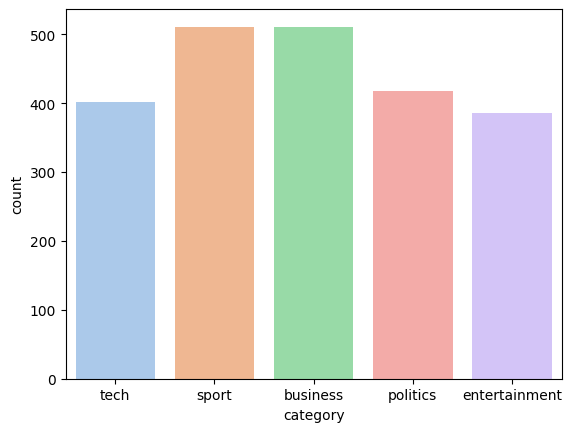

In [19]:
# Visualize categories for balance
sns.countplot(x="category",  hue='category', legend=False, data=df, palette='pastel')

In [20]:
# The count of words in the longest article across categories
categories=['tech', 'sport', 'business', 'politics', 'entertainment']
print("The longest article by category (Word Count):")
for category in categories:
    max_words = df[df['category'] == category]['body'].apply(lambda x: len(x.split())).max()
    print(f"{category.capitalize()}: {max_words} words")


The longest article by category (Word Count):
Tech: 2964 words
Sport: 1656 words
Business: 885 words
Politics: 4428 words
Entertainment: 3477 words


In [21]:

# The count of words in the shortest article across categories
print("The shortest article by category (Word Count):")
for category in categories:
    min_words = df[df['category'] == category]['body'].apply(lambda x: len(x.split())).min()
    print(f"- {category.capitalize():<15}: {min_words} words")

The shortest article by category (Word Count):
- Tech           : 157 words
- Sport          : 108 words
- Business       : 136 words
- Politics       : 84 words
- Entertainment  : 138 words


Note: the category of politics has the longest and the shortest articles

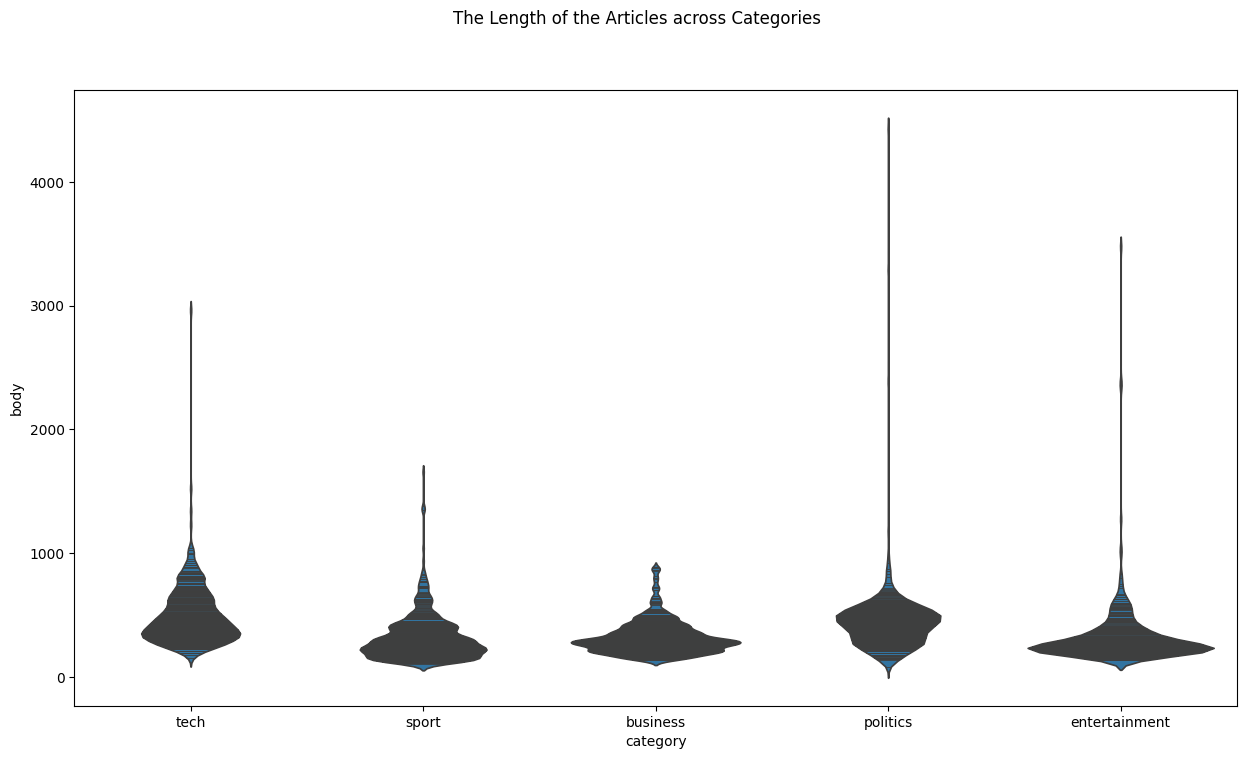

In [22]:
# Visualize length of articles across the categories for balance
fig, axs = plt.subplots(figsize=(15,8))
fig.suptitle("The Length of the Articles across Categories")
axs=sns.violinplot( x=df['category'], y=df["body"].apply(lambda x : len(x.split())), bw_adjust=.5, inner="stick")

plt.show()

<Axes: xlabel='category', ylabel='body'>

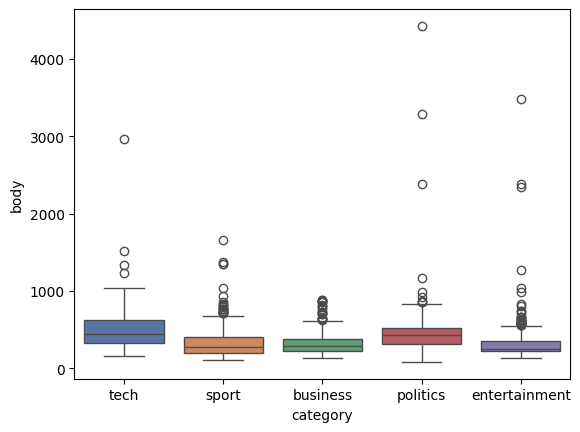

In [23]:
# Visualise article length for outliers
sns.boxplot(data=df, x='category', hue='category', y=df["body"].apply(lambda x : len(x.split())), palette='deep')

Note: further topic modelling and sentiment analysis may be biased by skewed article length.

LDA: Longer texts might dominate the topic distribution, while shorter texts may not provide enough data for clear topic identification.
BERTopic: even though it is a more advanced technique, extremely long texts may dominate the embeddings and clustering process, influencing the learned topics. Shorter texts might have less impact on the topic distribution, which can bias the model.

Possible solutions: 
normalization for LDA: stopword removal, stemming, lemmatization, truncation or better filtering short docs (max_words=500 or min_words=20)
normalization for BERTopic: chunking long texts and treating them as separate docs, embed the chunks, filtering very short texts.
